# Ball simulation

This part is dedicated to create the simulation of the ball dynamics, depending of the plateau angle.

## External imports

In [1]:
import numpy as np
import pandas as pd
import csv
import os
import matplotlib
import matplotlib.pyplot as plt

from torch.autograd import Variable
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from matplotlib import cm
from matplotlib.ticker import LinearLocator

%matplotlib notebook

## Internal imports

In [2]:
from src import *
from src.constants import DT
print(DT)

0.02


# Simulation

p_t+1 = p_t + s_t * dt

p = [x, y]

s = [d_x, d_y]

## Data preparation

In this part, the recorded data are loaded and prepared. The goal is to train the neural network on those datas.

In [3]:
data_file_names = os.listdir('src/data/train')
test_data_file_names = os.listdir('src/data/test')

In [4]:
datas = [pd.read_csv('src/data/train/{}'.format(file_name)) for file_name in data_file_names if 'ball' in file_name]
test_datas = [pd.read_csv('src/data/test/{}'.format(file_name)) for file_name in test_data_file_names if 'ball' in file_name]

Data visualisation

<IPython.core.display.Javascript object>


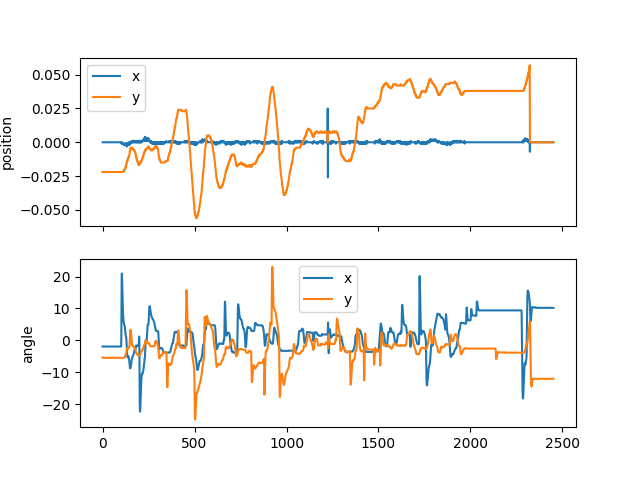

In [5]:
for data in datas[:1]:
    fig, axs = plt.subplots(2, 1, sharex=True)

    axs[0].plot(data['x'] - data['x'].shift(1), label='x')
    axs[0].plot(data['y'], label='y')
    axs[0].set_ylabel('position')
    axs[0].legend()

    axs[1].plot(data['angle_x'], label='x')
    axs[1].plot(data['angle_y'], label='y')
    axs[1].set_ylabel('angle')
    axs[1].legend()

    plt.show()

It is possible to see that at some moments, the ball was undetected. Either for a one timestep, either for the whole end.

Regressions are very sensitive to outliers, thus it is very important to remove those errors

In [6]:
for data in datas:
    data.drop(data.loc[data['x']==0].index, inplace=True)
for data in test_datas:
    data.drop(data.loc[data['x']==0].index, inplace=True)
    
datas[-1] = datas[-1].iloc[:380, :]

<IPython.core.display.Javascript object>


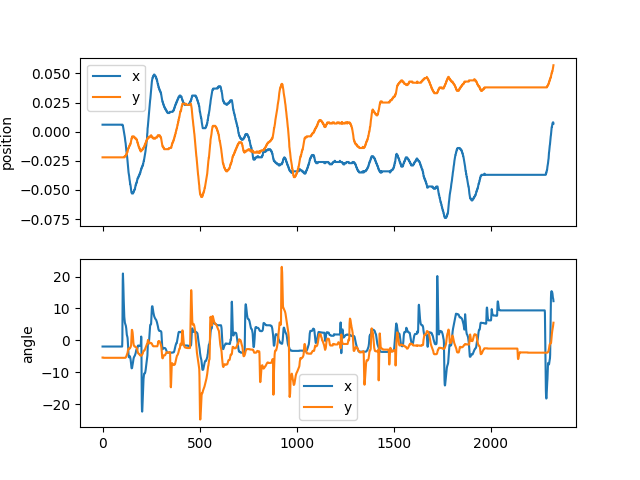

In [7]:
for data in datas[:1]:
    fig, axs = plt.subplots(2, 1, sharex=True)

    axs[0].plot(data['x'], label='x')
    axs[0].plot(data['y'], label='y')
    axs[0].set_ylabel('position')
    axs[0].legend()

    axs[1].plot(data['angle_x'], label='x')
    axs[1].plot(data['angle_y'], label='y')
    axs[1].set_ylabel('angle')
    axs[1].legend()

    plt.show()

In [8]:
'''for data in test_datas:
    fig, axs = plt.subplots(2, 1, sharex=True)

    axs[0].plot(data['x'], label='x')
    axs[0].plot(data['y'], label='y')
    axs[0].set_ylabel('position')
    axs[0].legend()

    axs[1].plot(data['angle_x'], label='x')
    axs[1].plot(data['angle_y'], label='y')
    axs[1].set_ylabel('angle')
    axs[1].legend()

    plt.show()'''

"for data in test_datas:\n    fig, axs = plt.subplots(2, 1, sharex=True)\n\n    axs[0].plot(data['x'], label='x')\n    axs[0].plot(data['y'], label='y')\n    axs[0].set_ylabel('position')\n    axs[0].legend()\n\n    axs[1].plot(data['angle_x'], label='x')\n    axs[1].plot(data['angle_y'], label='y')\n    axs[1].set_ylabel('angle')\n    axs[1].legend()\n\n    plt.show()"

Since all datasets are cleaned. It is now possible to compute the speed and concaten them.

In [9]:
lag: int = 8

for data in datas:
    data['sin_angle_x'] = np.sin(data['angle_x'] * np.pi / 180.)
    data['sin_angle_y'] = np.sin(data['angle_y'] * np.pi / 180.)
    data['d_x'] = ((data['x'] - data['x'].shift(lag + 1)) / (DT * (lag + 1))).rolling(window=lag+1).mean()
    data['d_y'] = ((data['y'] - data['y'].shift(lag + 1)) / (DT * (lag + 1))).rolling(window=lag+1).mean()
    data['tl'] = np.where((data['x']<0.) & (data['y']>0.), 1., 0.)
    data['br'] = np.where((data['x']>0.) & (data['y']<0.), 1., 0.)
    data['bl'] = np.where((data['x']<0.) & (data['y']<0.), 1., 0.)
    data['tr'] = np.where((data['x']>0.) & (data['y']>0.), 1., 0.)
    data['target_x'] = data['d_x'].shift(-1) - data['d_x']
    data['target_y'] = data['d_y'].shift(-1) - data['d_y']
    data.dropna(inplace=True)
for data in test_datas:
    data['sin_angle_x'] = np.sin(data['angle_x'] * np.pi / 180.)
    data['sin_angle_y'] = np.sin(data['angle_y'] * np.pi / 180.)
    data['d_x'] = ((data['x'] - data['x'].shift(lag + 1)) / (DT * (lag + 1))).rolling(window=lag+1).mean()
    data['d_y'] = ((data['y'] - data['y'].shift(lag + 1)) / (DT * (lag + 1))).rolling(window=lag+1).mean()
    data['tl'] = np.where((data['x']<0.) & (data['y']>0.), 1., 0.)
    data['br'] = np.where((data['x']>0.) & (data['y']<0.), 1., 0.)
    data['bl'] = np.where((data['x']<0.) & (data['y']<0.), 1., 0.)
    data['tr'] = np.where((data['x']>0.) & (data['y']>0.), 1., 0.)
    data['target_x'] = data['d_x'].shift(-1) - data['d_x']
    data['target_y'] = data['d_y'].shift(-1) - data['d_y']
    data.dropna(inplace=True)
    
data = datas[0]
for df in datas[0:]:
    data = pd.concat([data, df])
data.reset_index(inplace=True, drop=True)
print(data.head())

       x      y  angle_x  angle_y  input_x  input_y  sin_angle_x  sin_angle_y  \
0  0.006 -0.022   -1.929   -5.464   -0.211   -0.190    -0.033661     -0.09522   
1  0.006 -0.022   -1.929   -5.464   -0.206   -0.185    -0.033661     -0.09522   
2  0.006 -0.022   -1.929   -5.464   -0.205   -0.185    -0.033661     -0.09522   
3  0.006 -0.022   -1.929   -5.464   -0.203   -0.185    -0.033661     -0.09522   
4  0.006 -0.022   -1.929   -5.464   -0.205   -0.195    -0.033661     -0.09522   

   d_x  d_y   tl   br   bl   tr  target_x  target_y  
0  0.0  0.0  0.0  1.0  0.0  0.0       0.0       0.0  
1  0.0  0.0  0.0  1.0  0.0  0.0       0.0       0.0  
2  0.0  0.0  0.0  1.0  0.0  0.0       0.0       0.0  
3  0.0  0.0  0.0  1.0  0.0  0.0       0.0       0.0  
4  0.0  0.0  0.0  1.0  0.0  0.0       0.0       0.0  


<IPython.core.display.Javascript object>


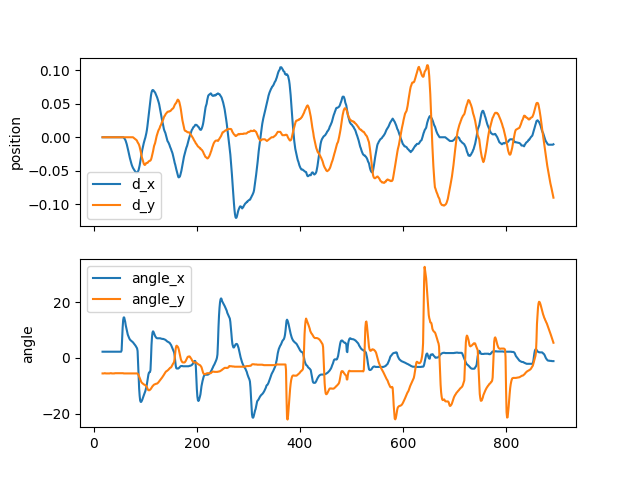

<IPython.core.display.Javascript object>


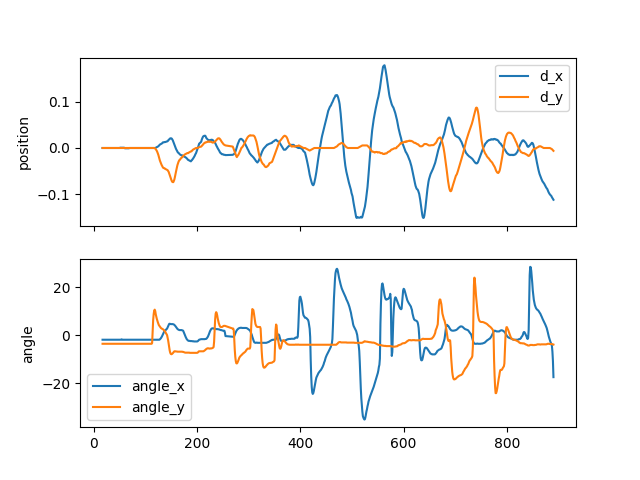

<IPython.core.display.Javascript object>


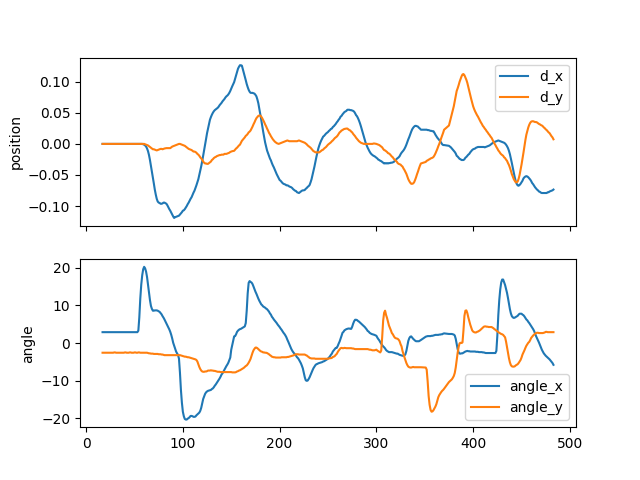

<IPython.core.display.Javascript object>


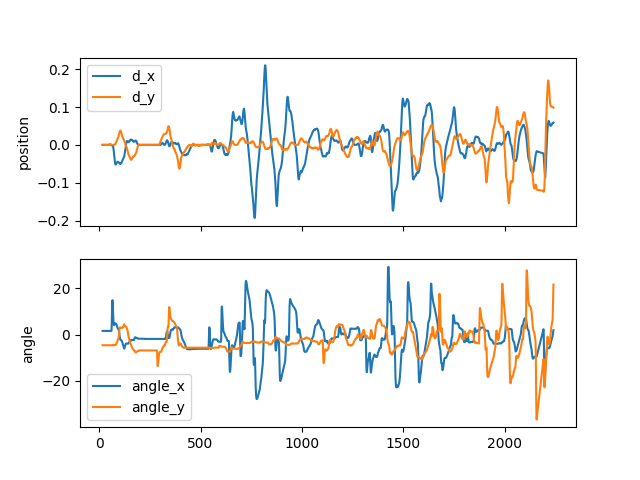

In [10]:
for data in test_datas:
    fig, axs = plt.subplots(2, 1, sharex=True)

    axs[0].plot(data['d_x'], label='d_x')
    axs[0].plot(data['d_y'], label='d_y')
    axs[0].set_ylabel('position')
    axs[0].legend()

    axs[1].plot(data['angle_x'], label='angle_x')
    axs[1].plot(data['angle_y'], label='angle_y')
    axs[1].set_ylabel('angle')
    axs[1].legend()

    plt.show()

## Scaling

In [11]:
max(- data['x'].min(), data['x'].max())

0.068

In [12]:
max(- data['y'].min(), data['y'].max())

0.055999999999999994

In [13]:
max(- data['d_x'].min(), data['d_x'].max(), - data['d_y'].min(), data['d_y'].max())

0.2104938271604938

In [14]:
data['d_x'].std()

0.05292105387668665

In [15]:
data['d_x'].abs().mean()

0.03529890292457965

In [16]:
data['sin_angle_x'].abs().mean()

0.09940343155397306

In [17]:
data['sin_angle_x'].std()

0.13555116171182982

In [18]:
data['target_x'].abs().mean()

0.0024456475036521443

## Inputs

- d_x
- d_y
- sin_angle_x * 7
- sin_angle_y * 7

## Output
- d_x
- d_y

In [19]:
x_np = data[['tr', 'tl','br', 'bl', 'd_x', 'd_y', 'sin_angle_x', 'sin_angle_y']].to_numpy()

x_np[:, 4] = x_np[:, 4]
x_np[:, 5] = x_np[:, 5]
x_np[:, 6] = x_np[:, 6] * 7.
x_np[:, 7] = x_np[:, 7] * 7.

y_np = data[['target_x', 'target_y']].to_numpy()

x = Variable(
    torch.from_numpy(
        x_np
    ).type(torch.FloatTensor)
)

y = Variable(
    torch.from_numpy(y_np).type(torch.FloatTensor)
)

<IPython.core.display.Javascript object>


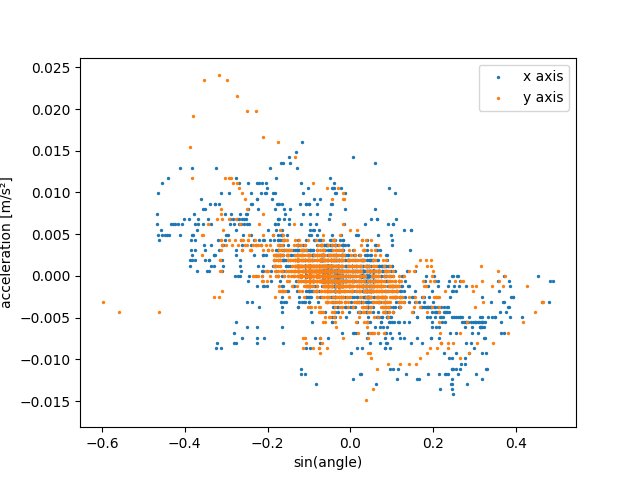

In [44]:
plt.figure()
plt.scatter(data['sin_angle_x'], y_np[:, 0], s=2, label='x axis')
plt.scatter(data['sin_angle_y'], y_np[:, 1], s=2, label='y axis')
plt.xlabel('sin(angle)')
plt.ylabel('acceleration [m/s²]')
plt.legend()

plt.show()

## Physic model

a = 2 * m_b * g * r_arm * r_b² / L / (m_b * r_b² + J_b) * sin(angle) = A * sin(angle)

d_x_t+1 = d_x_t + a * d_t = d_x_t + A' * sin(angle)

In [21]:
phy_x = x_np[:, 6:]
reg = LinearRegression(fit_intercept=False).fit(phy_x, y_np)
print('R2 score', reg.score(phy_x, y_np))
print('coef',reg.coef_)
print('coef',reg.intercept_)

R2 score 0.2772120639117811
coef [[-2.22790481e-03  9.23732861e-05]
 [-1.42330639e-04 -1.57377730e-03]]
coef 0.0


/home/benoit/.local/lib/python3.6/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


In [22]:
def recurcive_phy_sim(x_0, y_0, d_x_0, d_y_0, inputs):
    pos: np.ndarray = np.zeros((inputs.shape[0], 2))
    pos[0, 0] = x_0
    pos[0, 1] = y_0

    d_x = d_x_0
    d_y = d_y_0

    for i in range(1, inputs.shape[0]):
        pred = np.dot(reg.coef_, inputs[i - 1, :] * 7.) + reg.intercept_
        d_x += pred[0]
        d_y += pred[1]
        pos[i, 0] = max(min(pos[i - 1, 0] + d_x * DT, MAX_X), -MAX_X)
        pos[i, 1] = max(min(pos[i - 1, 1] + d_y * DT, MAX_Y), -MAX_Y)
    return pos

### Physical model with friction

d_x_t+1 = d_x_t + a * d_t = d_x_t + A' * sin(angle) + c_f * d_x

In [23]:
phy_x_f = x_np[:, 4:]
reg_f = LinearRegression(fit_intercept=False).fit(phy_x_f, y_np)
print('R2 score', reg_f.score(phy_x_f, y_np))
print('coef',reg_f.coef_)
print('coef',reg_f.intercept_)

R2 score 0.2975390289532463
coef [[ 1.10501191e-02  4.77946256e-03 -2.42551839e-03  5.07975073e-05]
 [-1.25620462e-03  7.75747139e-03 -1.23500586e-04 -1.65971125e-03]]
coef 0.0


/home/benoit/.local/lib/python3.6/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


In [24]:
def recurcive_phy_f_sim(x_0, y_0, d_x_0, d_y_0, inputs):
    pos: np.ndarray = np.zeros((inputs.shape[0], 2))
    pos[0, 0] = x_0
    pos[0, 1] = y_0
    
    inputs[:, 2] = inputs[:, 2] * 7.
    inputs[:, 3] = inputs[:, 3] * 7.

    d_x = d_x_0
    d_y = d_y_0

    for i in range(1, inputs.shape[0]):
        pred = np.dot(reg_f.coef_, inputs[i - 1, :]) + reg_f.intercept_
        d_x += pred[0]
        d_y += pred[1]
        pos[i, 0] = max(min(pos[i - 1, 0] + d_x * DT, MAX_X), -MAX_X)
        pos[i, 1] = max(min(pos[i - 1, 1] + d_y * DT, MAX_Y), -MAX_Y)
    return pos

### Physical model with position correction

d_x_t+1 = d_x_t + a * d_t = d_x_t + A' * c_f * d_x + sin(angle) + c_tr * tr + c_tl * tl * c_br * br + c_bl * bl

In [25]:
reg_corr = LinearRegression(fit_intercept=False).fit(x_np, y_np)
print('R2 score', reg_corr.score(x_np, y_np))
print('coef',reg_corr.coef_)
print('coef',reg_corr.intercept_)

R2 score 0.3408885581599521
coef [[-1.88144385e-03  6.57820679e-05 -1.14847952e-03  1.00364729e-04
   1.27315764e-02  6.02199191e-03 -2.11305368e-03 -1.92763530e-05]
 [-3.22852520e-04 -9.21267916e-04 -2.86563324e-04 -9.75582891e-04
  -1.86415277e-03  1.11329133e-02 -3.49756503e-04 -2.18023844e-03]]
coef 0.0


/home/benoit/.local/lib/python3.6/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


In [26]:
def recurcive_phy_corr_sim(x_0, y_0, d_x_0, d_y_0, inputs):
    pos: np.ndarray = np.zeros((inputs.shape[0], 2))
    pos[0, 0] = x_0
    pos[0, 1] = y_0
    
    inputs[:, 4] = inputs[:, 6] * 7.
    inputs[:, 5] = inputs[:, 7] * 7.

    d_x = d_x_0
    d_y = d_y_0

    for i in range(1, inputs.shape[0]):
        pred = np.dot(reg_corr.coef_, inputs[i - 1, :]) + reg_corr.intercept_
        d_x += pred[0]
        d_y += pred[1]
        pos[i, 0] = max(min(pos[i - 1, 0] + d_x * DT, MAX_X), -MAX_X)
        pos[i, 1] = max(min(pos[i - 1, 1] + d_y * DT, MAX_Y), -MAX_Y)
    return pos

# Neural network training
Since the ball behavior isn't linear, multiples NN are created and trained to model the system.

The inputs and targets are converted into pytorch format

In [27]:
nets = [BallNet1Hidden(8, 16, 2), BallNet1Hidden(8, 32, 2), BallNet1Hidden(8, 64, 2), 
        BallNet1Hidden(8, 128, 2), BallNet2Hidden(8, 16, 16, 2), BallNet2Hidden(8, 32, 16, 2),
        BallNet2Hidden(8, 64, 32, 2), BallNet2Hidden(8, 128, 64, 2), BallNet2Hidden(8, 128, 128, 2)]
nets = [BallNet1Hidden(8, 16, 2)]

In [28]:
nets = [train_ball_model(net, x, y, n_epoch=3000) for net in nets]

tensor(5.8030e-05, grad_fn=<MseLossBackward>)
tensor(5.8030e-05, grad_fn=<MseLossBackward>)
tensor(5.8030e-05, grad_fn=<MseLossBackward>)
tensor(5.8030e-05, grad_fn=<MseLossBackward>)
tensor(5.8030e-05, grad_fn=<MseLossBackward>)
tensor(5.8030e-05, grad_fn=<MseLossBackward>)
tensor(5.8030e-05, grad_fn=<MseLossBackward>)
tensor(5.8030e-05, grad_fn=<MseLossBackward>)
tensor(5.8030e-05, grad_fn=<MseLossBackward>)
tensor(5.8030e-05, grad_fn=<MseLossBackward>)
tensor(5.8030e-05, grad_fn=<MseLossBackward>)
tensor(5.8030e-05, grad_fn=<MseLossBackward>)
tensor(5.8030e-05, grad_fn=<MseLossBackward>)
tensor(5.8030e-05, grad_fn=<MseLossBackward>)
tensor(5.8030e-05, grad_fn=<MseLossBackward>)
tensor(5.8030e-05, grad_fn=<MseLossBackward>)
tensor(5.8030e-05, grad_fn=<MseLossBackward>)
tensor(5.8030e-05, grad_fn=<MseLossBackward>)
tensor(5.8030e-05, grad_fn=<MseLossBackward>)
tensor(5.8030e-05, grad_fn=<MseLossBackward>)
tensor(5.8030e-05, grad_fn=<MseLossBackward>)
tensor(5.8030e-05, grad_fn=<MseLos

## Test

### One step prediction

In [29]:
test_index = 1
test = test_datas[test_index][['tr', 'tl','br', 'bl', 'd_x', 'd_y', 'sin_angle_x', 'sin_angle_y']].to_numpy()
test_scaled = test.copy()

test_scaled[:, 4] = test_scaled[:, 4]
test_scaled[:, 5] = test_scaled[:, 5]
test_scaled[:, 6] = test_scaled[:, 6] * 7.
test_scaled[:, 7] = test_scaled[:, 7] * 7.

y_test = test_datas[test_index][['target_x', 'target_y']].to_numpy()

x_test = Variable(
    torch.from_numpy(
        test_scaled
    ).type(torch.FloatTensor)
)

In [30]:
y_phy = (np.dot(reg.coef_, test_scaled[:, 6:].T) + reg.intercept_).T

y_phy_f = (np.dot(reg_f.coef_, test_scaled[:, 4:].T) + reg.intercept_).T

y_phy_corr = (np.dot(reg_corr.coef_, test_scaled.T) + reg.intercept_).T

y_nn = nets[0].forward(x_test).detach().numpy()

print("Phy model r2:          ", r2_score(y_test, y_phy), "mse :", mean_squared_error(y_test, y_phy))
print("Phy friction model r2: ", r2_score(y_test, y_phy_f), "mse :", mean_squared_error(y_test, y_phy_f))
print("Phy corr model r2:     ", r2_score(y_test, y_phy_corr), "mse :", mean_squared_error(y_test, y_phy_corr))
print("Phy nn model r2:       ", r2_score(y_test, y_nn), "mse :", mean_squared_error(y_test, y_phy))

Phy model r2:           0.2611814477201257 mse : 6.315376246533409e-06
Phy friction model r2:  0.294983172968743 mse : 5.934695814784815e-06
Phy corr model r2:      0.2990435787389084 mse : 6.067737263592255e-06
Phy nn model r2:        -7.665357645529568 mse : 6.315376246533409e-06


### Long term perdiction

In [31]:
start = 500

x_0 = test_datas[test_index]['x'].iloc[start]
y_0 = test_datas[test_index]['y'].iloc[start]
d_x_0 = test_datas[test_index]['d_x'].iloc[start]
d_y_0 = test_datas[test_index]['d_y'].iloc[start]

phy_pos = recurcive_phy_sim(x_0, y_0, d_x_0, d_y_0, test[start:, 6:])

phy_pos_f = recurcive_phy_f_sim(x_0, y_0, d_x_0, d_y_0, test[start:, 4:])

phy_pos_corr = recurcive_phy_corr_sim(x_0, y_0, d_x_0, d_y_0, test[start:, :])

In [32]:
pos_nn = nets[0].recurcive_predict(x_0, y_0, d_x_0, d_y_0, test[start:, :])

<IPython.core.display.Javascript object>


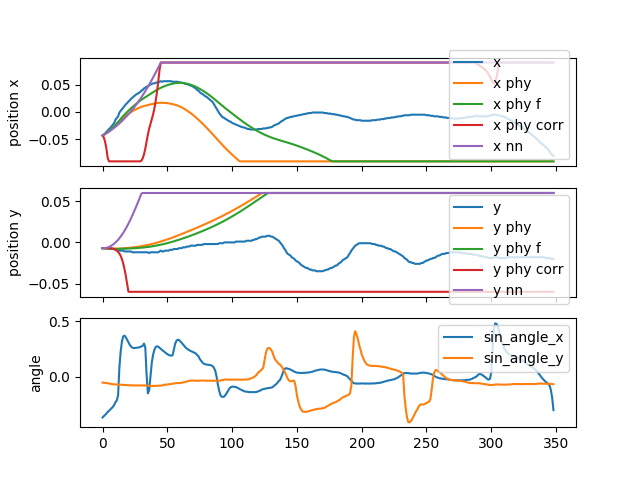

In [33]:
fig, axs = plt.subplots(3, 1, sharex=True)

axs[0].plot(test_datas[test_index]['x'].iloc[start:].to_numpy(), label='x')
axs[0].plot(phy_pos[:, 0], label='x phy')
axs[0].plot(phy_pos_f[:, 0], label='x phy f')
axs[0].plot(phy_pos_corr[:, 0], label='x phy corr')
axs[0].plot(pos_nn[:, 0], label='x nn')
axs[0].set_ylabel('position x')
axs[0].legend()

axs[1].plot(test_datas[test_index]['y'].iloc[start:].to_numpy(), label='y')
axs[1].plot(phy_pos[:, 1], label='y phy')
axs[1].plot(phy_pos_f[:, 1], label='y phy f')
axs[1].plot(phy_pos_corr[:, 1], label='y phy corr')
axs[1].plot(pos_nn[:, 1], label='y nn')
axs[1].set_ylabel('position y')
axs[1].legend()

axs[2].plot(test_datas[test_index]['sin_angle_x'].iloc[start:].to_numpy(), label='sin_angle_x')
axs[2].plot(test_datas[test_index]['sin_angle_y'].iloc[start:].to_numpy(), label='sin_angle_y')
axs[2].set_ylabel('angle')
axs[2].legend()

plt.show()

In [34]:
ball = {
    'phy_i_coef': reg_f.coef_.tolist(),
    's_scaling': 1.,
    'sin_scaling': 7.
}

with open('src/data/ball.json', 'w') as json_file:
    json.dump(ball, json_file)

In [35]:
a = BallSimulation()

{'phy_i_coef': [[0.01105011910592794, 0.004779462563517304, -0.0024255183933575607, 5.079750726810794e-05], [-0.001256204619688538, 0.007757471394872772, -0.00012350058574460247, -0.0016597112513896189]], 's_scaling': 1.0, 'sin_scaling': 7.0}
